<a href="https://colab.research.google.com/github/AritraStark/Deeplense_GSOC_2022/blob/main/Deeplense_Test_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Specific Test IV. Exploring Equivariant Neural Networks**

**Task:** Use an Equivariant Neural Network of your choice to build a robust and efficient model for binary classification or unsupervised anomaly detection on the provided dataset. In the case of unsupervised anomaly detection, train your model to learn the distribution of the provided strong lensing images with no substructure. Please implement your approach in PyTorch or Keras and discuss your strategy.

**Dataset:** https://drive.google.com/file/d/16Y1taQoTeUTP5rGpB0tuPZ_S30acvnqr/view?usp=sharing

**Dataset Description:** A set of simulated strong gravitational lensing images with and without substructure. 

**Evaluation Metrics:** ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve)\

Downloading the data:

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!tar --extract --file '/content/gdrive/MyDrive/lenses.tgz' 
print('Extraction done.')

Mounted at /content/gdrive
Extraction done.


Setting up imports: 

In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve

Extracting the data from the lense images:

In [4]:
X_data = []
Y_data = []

#substructure data
sub = os.listdir('/content/lenses/sub')
for i in sub:
    img = cv2.imread('/content/lenses/sub/' + i)
    img = img / 255.0
    X_data.append(img)
    Y_data.append(1)

#no-substructure data
no_sub = os.listdir('/content/lenses/no_sub')
for i in no_sub:
    img = cv2.imread('/content/lenses/no_sub/' + i)
    img = img / 255.0
    X_data.append(img)
    Y_data.append(0)

Shuffling to introduce randomness in the data:

In [5]:
data = list(zip(X_data, Y_data))
np.random.shuffle(data)
X_data, Y_data = zip(*data)

#delete to free redundant space
del data

X_data = np.array(X_data)
Y_data = np.array(Y_data)

Visualising the images belonging to the two classes: 

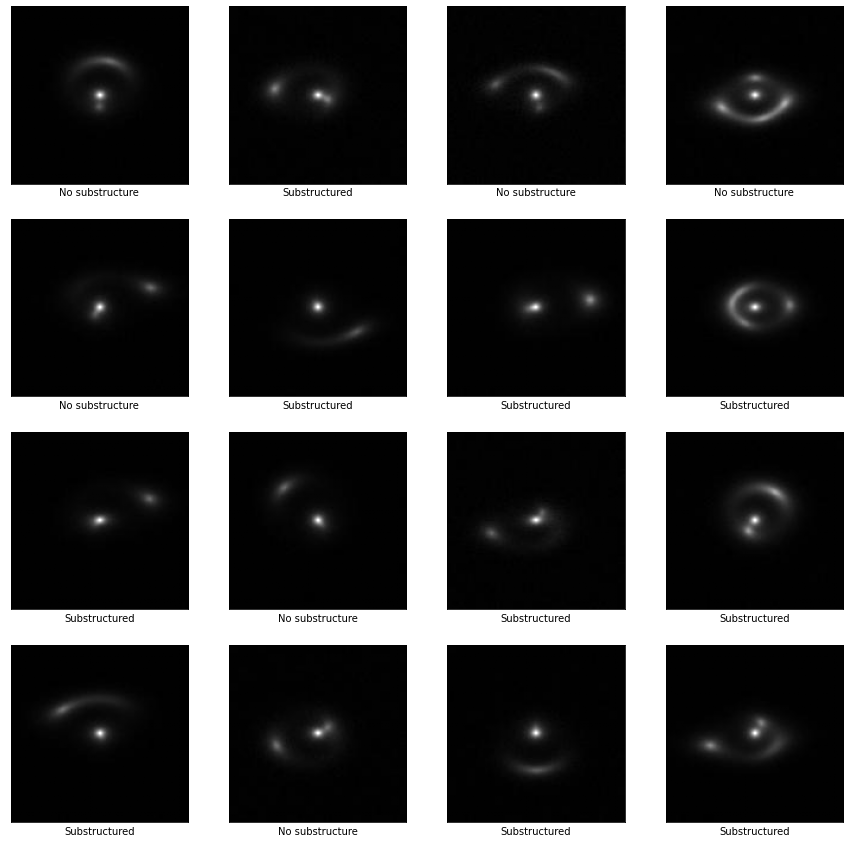

In [6]:
classes = ["Substructured", "No substructure"]
plt.figure(figsize=(15, 15))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    num = np.random.randint(0, len(X_data))
    plt.imshow(X_data[num])
    plt.xlabel(classes[Y_data[num]])
plt.show()

Splitting the data into training and validation:

In [7]:
X_train , X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42, shuffle=True)
X_data.shape, Y_data.shape

((10000, 150, 150, 3), (10000,))

Deleting large variables to free up memory:

In [8]:
del X_data, Y_data
del img, no_sub, sub

Defining the model and compiling: 

In [9]:
model = tf.keras.applications.ResNet50V2(
    include_top=True, 
    input_shape=(150, 150, 3),
    weights=None,
    classes=2,
    classifier_activation='softmax'
)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 77, 77, 64)   0           ['conv1_conv[0][0]']    

Defining a callback to save the best weight for using it in ROC curve:

In [10]:
checkpoint_filepath = 'weights.{epoch:02d}-{val_loss:.2f}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

Fitting and training the model: 

In [11]:
model.fit(
    X_train, 
    Y_train, 
    epochs=20, 
    validation_data=(X_test, Y_test),
    callbacks=[model_checkpoint_callback]
)

Epoch 1/20
250/250 [==============================] - ETA: 0s - loss: 0.6306 - accuracy: 0.6532
Epoch 1: val_accuracy improved from -inf to 0.50950, saving model to weights.01-9.60.h5
250/250 [==============================] - 113s 383ms/step - loss: 0.6306 - accuracy: 0.6532 - val_loss: 9.5994 - val_accuracy: 0.5095
Epoch 2/20
250/250 [==============================] - ETA: 0s - loss: 0.4345 - accuracy: 0.8026
Epoch 2: val_accuracy did not improve from 0.50950
250/250 [==============================] - 93s 370ms/step - loss: 0.4345 - accuracy: 0.8026 - val_loss: 11.6864 - val_accuracy: 0.4900
Epoch 3/20
250/250 [==============================] - ETA: 0s - loss: 0.3150 - accuracy: 0.8699
Epoch 3: val_accuracy improved from 0.50950 to 0.54800, saving model to weights.03-2.88.h5
250/250 [==============================] - 94s 376ms/step - loss: 0.3150 - accuracy: 0.8699 - val_loss: 2.8767 - val_accuracy: 0.5480
Epoch 4/20
250/250 [==============================] - ETA: 0s - loss: 0.2544 -

Delete to free up memory:

In [12]:
del X_train, Y_train

Predict on the validation data and load the best saved weight:

In [13]:
model.load_weights('weights.08-0.08.h5')
predictions = model.predict(X_test)
temp_predictions = []
for i in range(len(predictions)):
    k = np.argmax(predictions[i])
    temp_predictions.append(k)

temp_predictions = np.array(temp_predictions)

Plotting the ROC AUC curve:

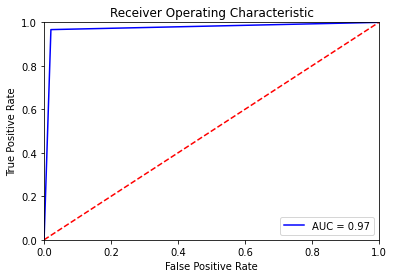

In [14]:
fpr, tpr, thresholds = roc_curve(Y_test, temp_predictions)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()